# Image coloring using Generative Adversarial Networks

Authors:
- Daniel García Algora
- David García Guillén
- Carlos Hernández López
- Álvaro Tena Tamayo

---

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
from skimage.color import rgb2lab, lab2rgb
from keras.datasets import cifar10
import cv2
from joblib import Parallel, delayed



import tensorflow as tf
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model

### Image preprocessing

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


In [19]:
def rgb_to_grayscale(images):
    """
    Converts RGB image list to grayscale.

    Args:
    images (list of numpy arrays): RGB image list.

    Returns:
    list of numpy arrays: grayscale image list.
    """
    grayscale_images = []
    for img in images:
        grayscale_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        grayscale_images.append(grayscale_img)
    return grayscale_images

In [23]:
x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def show_random_image(x_data, dataset_name, title=None, cmap=None):
    """
    Muestra una imagen aleatoria de un conjunto de datos.

    Args:
    x_data (numpy array): Dataset containing images.
    dataset_name (str): Dataset's name.
    title (str, opcional): Image title.
    cmap (str, opcional): Colour map.

    Returns:
    None
    """
    # select random image
    random_index = np.random.randint(0, len(x_data))
    random_image = x_data[random_index]

    # plot image
    plt.imshow(random_image, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.suptitle(f'Random {dataset_name} image')
    plt.show()

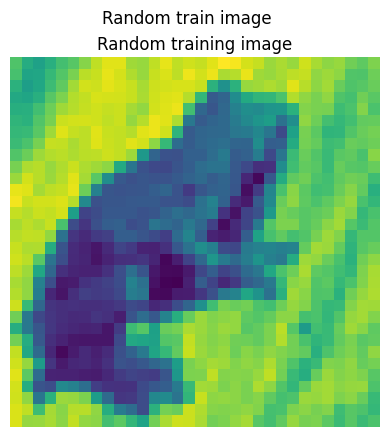

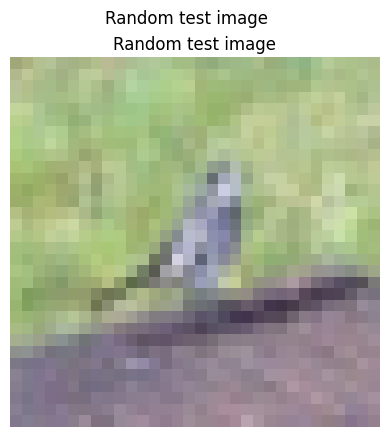

In [34]:
show_random_image(x_train_gray, 'train', title="Random training image")
show_random_image(x_test, 'test', title="Random test image")


In [38]:
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [39]:
train_dataset = Dataset(x_train_gray, x_train)
test_dataset = Dataset(x_test_gray, x_test)

training_data = train_dataset.x

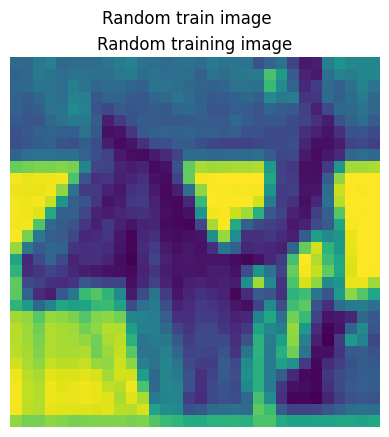

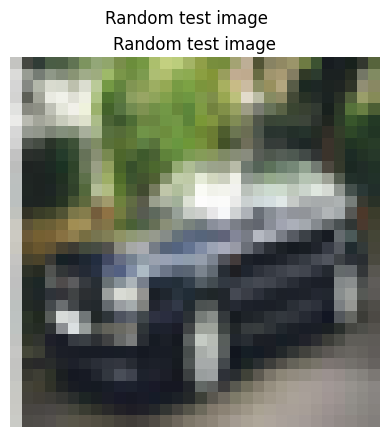

In [40]:
show_random_image(train_dataset.x, 'train', title="Random training image")
show_random_image(test_dataset.y, 'test', title="Random test image")


## Model design (convolutional)

In [2]:
def make_generator_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=2, activation='relu'))
    model.add(BatchNormalization())
    # model = MaxPooling2D(pool_size=(2, 2))(model)

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', strides=2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    # model = MaxPooling2D(pool_size=(2, 2))(model)

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(2, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    # self.model = BatchNormalization()(self.model)
    # self.model = merge(inputs=[self.g_input, self.model], mode='concat')
    # self.model = Activation('linear')(self.model)
    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model